# Emotion Classification Models Comparison

In this notebook, we will compare two pretrained models for emotion classification:

1. **TF-IDF + Logistic Regression** – a simple yet effective model.
2. **DistilBERT** – a transformer-based model.

We will evaluate both models on the test dataset, visualize their performance with **confusion matrices**, and discuss observations.


In [2]:
import pandas as pd
import joblib
import torch
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

sys.path.append(os.path.abspath("../src"))
# Paths and settings
from config import TEST_PATH, MODEL_PATH, VECTORIZER_PATH, BERT_MODEL_DIR, BERT_MAX_LEN

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Test Data

We will load the test dataset containing text samples and labels.


In [3]:
test_df = pd.read_csv(TEST_PATH)
X_test = test_df['text'].tolist()
y_test = test_df['label'].tolist()

## TF-IDF + Logistic Regression

We load the pretrained TF-IDF + Logistic Regression model, make predictions on the test set, 
and evaluate its performance using accuracy, classification report, and confusion matrix.


--- TF-IDF + Logistic Regression ---
Accuracy: 0.891
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       581
           1       0.94      0.89      0.91       695
           2       0.71      0.89      0.79       159
           3       0.88      0.91      0.89       275
           4       0.89      0.83      0.86       224
           5       0.61      0.91      0.73        66

    accuracy                           0.89      2000
   macro avg       0.83      0.89      0.85      2000
weighted avg       0.90      0.89      0.89      2000



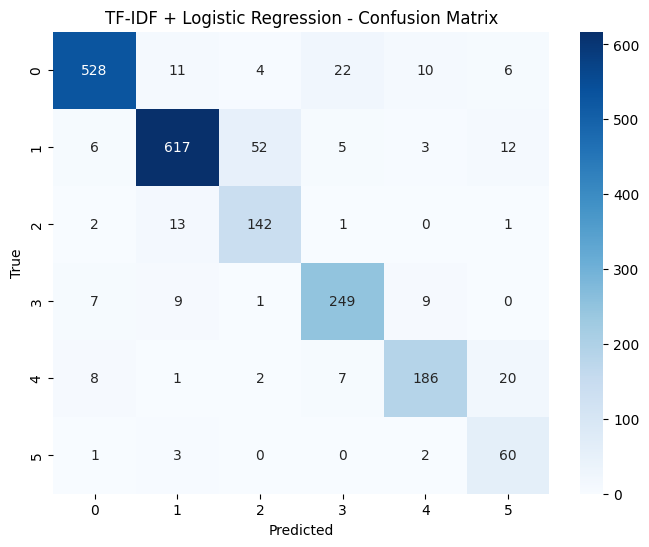

In [4]:
# Load TF-IDF model and vectorizer
tfidf_model = joblib.load(MODEL_PATH)
vectorizer = joblib.load(VECTORIZER_PATH)

# Transform test data
X_test_tfidf = vectorizer.transform(X_test)

# Predict
y_pred_tfidf = tfidf_model.predict(X_test_tfidf)

# Metrics
print('--- TF-IDF + Logistic Regression ---')
print('Accuracy:', accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

# Confusion matrix
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
plt.figure(figsize=(8,6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues')
plt.title('TF-IDF + Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## DistilBERT Model

We load the pretrained DistilBERT model, tokenize the test data, predict labels, 
and evaluate the model using accuracy, classification report, and confusion matrix.


Loading weights: 100%|██████████| 104/104 [00:00<00:00, 1179.58it/s, Materializing param=pre_classifier.weight]                                  


--- DistilBERT ---
Accuracy: 0.9285
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       581
           1       0.97      0.94      0.95       695
           2       0.80      0.90      0.85       159
           3       0.93      0.92      0.92       275
           4       0.88      0.87      0.88       224
           5       0.71      0.71      0.71        66

    accuracy                           0.93      2000
   macro avg       0.88      0.89      0.88      2000
weighted avg       0.93      0.93      0.93      2000



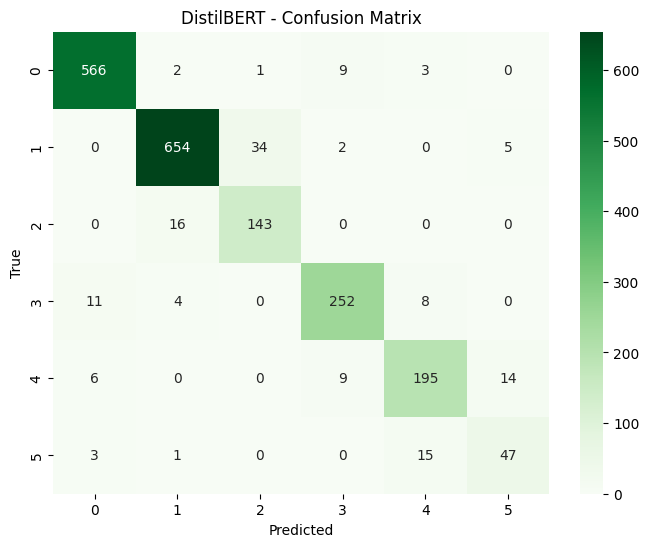

In [5]:
# Load tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained(BERT_MODEL_DIR)
bert_model = DistilBertForSequenceClassification.from_pretrained(BERT_MODEL_DIR).to(DEVICE)

# Tokenize test data
encodings = tokenizer(X_test, truncation=True, padding=True, max_length=BERT_MAX_LEN, return_tensors='pt')
input_ids = encodings['input_ids'].to(DEVICE)
attention_mask = encodings['attention_mask'].to(DEVICE)

# Predict
with torch.no_grad():
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    y_pred_bert = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# Metrics
print('--- DistilBERT ---')
print('Accuracy:', accuracy_score(y_test, y_pred_bert))
print(classification_report(y_test, y_pred_bert))

# Confusion matrix
cm_bert = confusion_matrix(y_test, y_pred_bert)
plt.figure(figsize=(8,6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens')
plt.title('DistilBERT - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Overall : 
- Models work good on the text that are alike to the training set
- Problem occurs with the "not happy" or other negative words because of the training set. There is not that many example of negative texts so that model can learn well. For that reason it will be better to collect those example. BERT model DID NOT solve that issue as well which is completely showing that the problem is with the dataset and the importance of different words that model learns during training. It completely ignores the word not even though i made the preprocessing the way in which thoose 'stopwords' would not be removed.
- From the confusion matrix we can clearly see that the model struggles with the class 5 due to the underrepresentation of this class (it is only 3% of the training set). It can be fixed by setting weightage to that class more but the better solution will be to just collect more data of this class 